In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Necessary for loading data and modeling in PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import product

# Load Data

In [2]:
df = pd.read_csv('Etiquetas.csv')
df

,age_group,MMSE_Score,Gender
0,2,30,1
1,2,30,1
2,2,30,1
3,2,30,1
4,2,30,1
...,...,...,...
795,2,30,1
796,2,30,1
797,2,30,1
798,2,30,1


In [17]:
df.columns

Index(['age_group', 'MMSE_Score', 'Gender'], dtype='object')

In [14]:
df['Gender'].value_counts(normalize=True)

,proportion
Gender,
1,0.62
0,0.38


In [49]:

X = torch.tensor(np.load("/content/data LSTM.npy"))
X.shape

y = torch.tensor(df['Gender'])
y.shape

torch.Size([800])

# Model

In [71]:
class LSTMRegression(torch.nn.Module):

    def __init__(self,n_features,seq_length, n_hidden, n_layers):
        super(LSTMRegression, self).__init__()

        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        self.l_lstm = torch.nn.LSTM(input_size = self.n_features,
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers,
                                 batch_first = True, dropout=0.5)


        self.l_linear = torch.nn.Linear(self.n_hidden, 1)



    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x, (self.hidden, _) = self.l_lstm(x)
        return self.l_linear(x[:,-1,:])


# Train

In [61]:

def makeSplits(data, label):
    # Define the percentages for splits
    perc = [0.7, 0.2, 0.1]

    # Calculate the sizes for each split
    sizes = [int(perc[i] * len(data)) for i in range(len(perc))]

    train, val, test = sizes[0], sizes[1], sizes[2]

    # Slice the data tensor (3D) and label tensor (1D) for each split
    X_train = data[:train, :, :]
    y_train = label[:train]
    X_val = data[train:train + val, :, :]
    y_val = label[train:train + val]
    X_test = data[train + val:train + val + test, :, :]
    y_test = label[train + val:train + val + test]

    return X_train, y_train, X_val, y_val, X_test, y_test


def train_model(model, train_loader, X_val, y_val, criterion, num_epochs, learning_rate, patience=20):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Early stopping variables
    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct_train, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            # Training accuracy (threshold logits at 0.5)
            y_pred_class = torch.sigmoid(y_pred) >= 0.5
            correct_train += (y_pred_class == y_batch).sum().item()
            total_train += y_batch.size(0)

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train * 100)

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val).item()
            val_losses.append(val_loss)

            # Validation accuracy
            y_val_pred_class = torch.sigmoid(y_val_pred) >= 0.5
            correct_val = (y_val_pred_class == y_val).sum().item()
            val_accuracies.append(correct_val / y_val.size(0) * 100)

        print(
            f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
            f"Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%"
        )

        # Early stopping check
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model = model.state_dict()
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Return the best model and metrics
    model.load_state_dict(best_model)  # Load the best model
    return train_losses, val_losses, train_accuracies, val_accuracies



# Plot Metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(epochs, train_losses, label="Train Loss", color="blue")
    axes[0, 0].plot(epochs, val_losses, label="Validation Loss", color="green")
    axes[0, 0].set_title("Training Loss")
    axes[0, 0].legend()

    axes[0, 1].plot(epochs, train_accuracies, label="Train Accuracy", color="red")
    axes[0, 1].set_title("Training Accuracy")
    axes[0, 1].legend()

    axes[1, 0].plot(epochs, val_losses, label="Validation Loss", color="green")
    axes[1, 0].set_title("Validation Loss")
    axes[1, 0].legend()

    axes[1, 1].plot(epochs, val_accuracies, label="Validation Accuracy", color="purple")
    axes[1, 1].set_title("Validation Accuracy")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

def pipeline(data, label):
    # Splits
    X_train, y_train, X_val, y_val, X_test, y_test = makeSplits(data, label)

    # Convert to tensors
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
    X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)

    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)


    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    # Hyperparameter search space
    learning_rates = [0.0001, 0.005, 0.001]
    hidden_sizes = [16,20, 32]
    num_layers_list = [2, 3]


    # Best model tracking
    best_val_accuracy = 0
    best_metrics = None
    best_model = None

    criterion = nn.BCEWithLogitsLoss()

    for lr, hidden_size, num_layers in product(learning_rates, hidden_sizes, num_layers_list):
        print(f"\nTesting Model: lr={lr}, hidden_size={hidden_size}, num_layers={num_layers}")
        model = LSTMRegression(n_features=X_train.shape[2], seq_length=X_train.shape[1], n_hidden=hidden_size, n_layers=num_layers)

        # Train model
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, X_val, y_val, criterion, num_epochs=50, learning_rate=lr
        )

        # Track best model
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_metrics = (train_losses, val_losses, train_accuracies, val_accuracies)
            best_model = model.state_dict()
            print(f"New Best Model Found: Val Accuracy = {best_val_accuracy:.2f}%")

    # Save the best model
    torch.save(best_model, "best_model5.pth")
    print(f"\nBest Model Saved with Validation Accuracy: {best_val_accuracy:.2f}%")


    X_test = X_test.to(torch.float32)


    model.load_state_dict(best_model)
    model.eval()

    # Calculate Test Accuracy
    with torch.no_grad():
        y_test_pred = model(X_test)
        y_test_pred_class = (torch.sigmoid(y_test_pred) >= 0.5).long()

        # Ensure both tensors are 1D for comparison
        y_test = y_test.squeeze()
        y_test_pred_class = y_test_pred_class.squeeze()

        # Compare predictions with ground truth
        correct_test = (y_test_pred_class == y_test).sum().item()
        total_test = y_test.size(0)

        test_accuracy = correct_test / total_test * 100

    print(f"Test Accuracy of Best Model: {test_accuracy:.2f}%")


    # Plot the best model
    if best_metrics:
        train_losses, val_losses, train_accuracies, val_accuracies = best_metrics
        plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [50]:
import torch
import numpy as np

# Call the function
X_train, y_train, X_val, y_val, X_test, y_test = makeSplits(X, y)

# Print shapes to verify
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


X_train: torch.Size([560, 51, 360]) y_train: torch.Size([560])
X_val: torch.Size([160, 51, 360]) y_val: torch.Size([160])
X_test: torch.Size([80, 51, 360]) y_test: torch.Size([80])


<ipython-input-19-9a170d4c19cc>:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
<ipython-input-19-9a170d4c19cc>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
<ipython-input-19-9a170d4c19cc>:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
<ipython-input-19-9a170d4c19cc>


Testing Model: lr=0.0001, hidden_size=20, num_layers=2
Epoch 1/50, Train Loss: 0.6922, Val Loss: 0.6901, Train Acc: 53.04%, Val Acc: 60.00%
Epoch 2/50, Train Loss: 0.6895, Val Loss: 0.6882, Train Acc: 54.64%, Val Acc: 61.25%
Epoch 3/50, Train Loss: 0.6874, Val Loss: 0.6862, Train Acc: 57.68%, Val Acc: 60.00%
Epoch 4/50, Train Loss: 0.6838, Val Loss: 0.6842, Train Acc: 62.86%, Val Acc: 61.88%
Epoch 5/50, Train Loss: 0.6816, Val Loss: 0.6822, Train Acc: 61.96%, Val Acc: 65.00%
Epoch 6/50, Train Loss: 0.6788, Val Loss: 0.6800, Train Acc: 65.89%, Val Acc: 65.00%
Epoch 7/50, Train Loss: 0.6756, Val Loss: 0.6777, Train Acc: 67.32%, Val Acc: 66.25%
Epoch 8/50, Train Loss: 0.6728, Val Loss: 0.6752, Train Acc: 69.64%, Val Acc: 68.12%
Epoch 9/50, Train Loss: 0.6709, Val Loss: 0.6726, Train Acc: 70.71%, Val Acc: 66.25%
Epoch 10/50, Train Loss: 0.6669, Val Loss: 0.6697, Train Acc: 71.43%, Val Acc: 66.88%
Epoch 11/50, Train Loss: 0.6618, Val Loss: 0.6666, Train Acc: 74.46%, Val Acc: 70.62%
Epoch 1

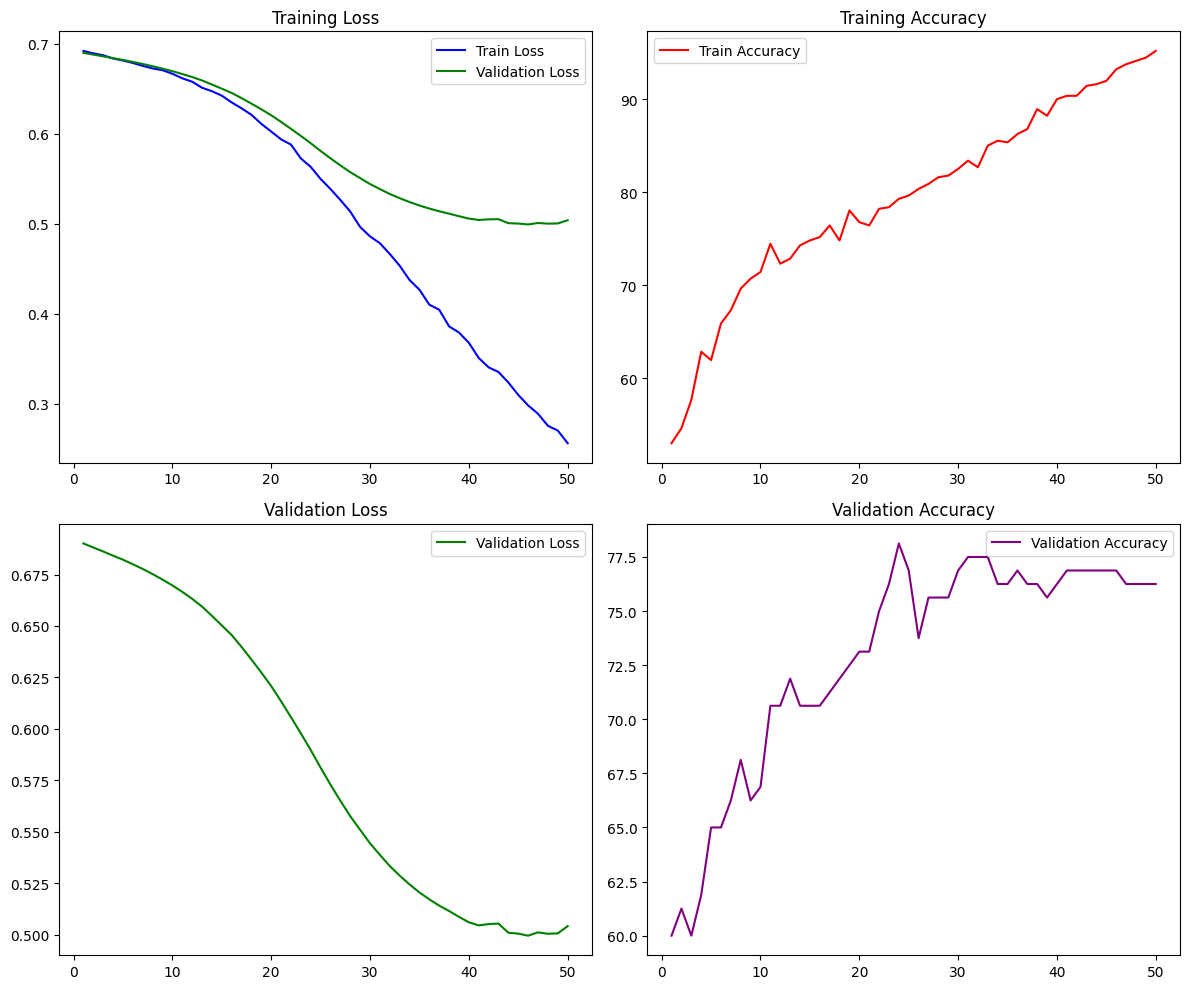

In [20]:
pipeline(X,y)

In [72]:

def makeSplits(data, label):
    # Define the percentages for splits
    perc = [0.7, 0.2, 0.1]

    # Calculate the sizes for each split
    sizes = [int(perc[i] * len(data)) for i in range(len(perc))]

    train, val, test = sizes[0], sizes[1], sizes[2]

    # Slice the data tensor (3D) and label tensor (1D) for each split
    X_train = data[:train, :, :]
    y_train = label[:train]
    X_val = data[train:train + val, :, :]
    y_val = label[train:train + val]
    X_test = data[train + val:train + val + test, :, :]
    y_test = label[train + val:train + val + test]

    return X_train, y_train, X_val, y_val, X_test, y_test


def train_model(model, train_loader, X_val, y_val, criterion, num_epochs, learning_rate, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Early stopping variables
    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct_train, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            # Training accuracy (threshold logits at 0.5)
            y_pred_class = torch.sigmoid(y_pred) >= 0.5
            correct_train += (y_pred_class == y_batch).sum().item()
            total_train += y_batch.size(0)

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train * 100)

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val).item()
            val_losses.append(val_loss)

            # Validation accuracy
            y_val_pred_class = torch.sigmoid(y_val_pred) >= 0.5
            correct_val = (y_val_pred_class == y_val).sum().item()
            val_accuracies.append(correct_val / y_val.size(0) * 100)

        print(
            f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
            f"Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%"
        )

        # Early stopping check
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model = model.state_dict()
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Return the best model and metrics
    model.load_state_dict(best_model)  # Load the best model
    return train_losses, val_losses, train_accuracies, val_accuracies



# Plot Metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(epochs, train_losses, label="Train Loss", color="blue")
    axes[0, 0].plot(epochs, val_losses, label="Validation Loss", color="green")
    axes[0, 0].set_title("Training Loss")
    axes[0, 0].legend()

    axes[0, 1].plot(epochs, train_accuracies, label="Train Accuracy", color="red")
    axes[0, 1].set_title("Training Accuracy")
    axes[0, 1].legend()

    axes[1, 0].plot(epochs, val_losses, label="Validation Loss", color="green")
    axes[1, 0].set_title("Validation Loss")
    axes[1, 0].legend()

    axes[1, 1].plot(epochs, val_accuracies, label="Validation Accuracy", color="purple")
    axes[1, 1].set_title("Validation Accuracy")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


def pipeline(data, label):
    # Splits
    X_train, y_train, X_val, y_val, X_test, y_test = makeSplits(data, label)

    # Convert to tensors
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # DataLoader for training
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    # Hyperparameter search space
    learning_rates = [0.0001, 0.0005]
    hidden_sizes = [20, 32]
    num_layers_list = [2, 3]

    # Best model tracking
    best_val_accuracy = 0
    best_metrics = None
    best_checkpoint = None

    criterion = nn.BCEWithLogitsLoss()

    for lr, hidden_size, num_layers in product(learning_rates, hidden_sizes, num_layers_list):
        print(f"\nTesting Model: lr={lr}, hidden_size={hidden_size}, num_layers={num_layers}")
        model = LSTMRegression(n_features=X_train.shape[2], seq_length=X_train.shape[1],
                               n_hidden=hidden_size, n_layers=num_layers)

        # Train model
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, X_val, y_val, criterion, num_epochs=50, learning_rate=lr
        )

        # Track best model
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_metrics = (train_losses, val_losses, train_accuracies, val_accuracies)
            best_checkpoint = {
                'state_dict': model.state_dict(),
                'n_hidden': hidden_size,
                'n_layers': num_layers
            }
            print(f"New Best Model Found: Val Accuracy = {best_val_accuracy:.2f}%")

    # Save the best model and its hyperparameters
    torch.save(best_checkpoint, "best_model.pth")
    print(f"\nBest Model Saved with Validation Accuracy: {best_val_accuracy:.2f}%")

    # Load the best model for testing
    checkpoint = torch.load("best_model.pth")
    model = LSTMRegression(n_features=X_train.shape[2], seq_length=X_train.shape[1],
                           n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    # Calculate Test Accuracy
    with torch.no_grad():
        y_test_pred = model(X_test)
        y_test_pred_class = (torch.sigmoid(y_test_pred) >= 0.5).long()

        # Ensure both tensors have matching shapes
        y_test = y_test.squeeze()
        y_test_pred_class = y_test_pred_class.squeeze()

        # Compare predictions with ground truth
        correct_test = (y_test_pred_class == y_test).sum().item()
        total_test = y_test.size(0)

        test_accuracy = correct_test / total_test * 100

    print(f"Test Accuracy of Best Model: {test_accuracy:.2f}%")

    # Plot the best model metrics
    if best_metrics:
        train_losses, val_losses, train_accuracies, val_accuracies = best_metrics
        plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    return test_accuracy


Testing Model: lr=0.0001, hidden_size=20, num_layers=2

<ipython-input-72-67b6538c59ab>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
<ipython-input-72-67b6538c59ab>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
<ipython-input-72-67b6538c59ab>:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch


Testing Model: lr=0.0001, hidden_size=20, num_layers=2
Epoch 1/50, Train Loss: 0.6791, Val Loss: 0.6913, Train Acc: 64.46%, Val Acc: 50.62%
Epoch 2/50, Train Loss: 0.6751, Val Loss: 0.6917, Train Acc: 66.07%, Val Acc: 50.00%
Epoch 3/50, Train Loss: 0.6719, Val Loss: 0.6923, Train Acc: 66.79%, Val Acc: 50.62%
Epoch 4/50, Train Loss: 0.6681, Val Loss: 0.6929, Train Acc: 66.96%, Val Acc: 50.62%
Epoch 5/50, Train Loss: 0.6674, Val Loss: 0.6936, Train Acc: 67.50%, Val Acc: 50.62%
Epoch 6/50, Train Loss: 0.6621, Val Loss: 0.6943, Train Acc: 67.32%, Val Acc: 50.62%
Early stopping at epoch 6
New Best Model Found: Val Accuracy = 50.62%

Testing Model: lr=0.0001, hidden_size=20, num_layers=3
Epoch 1/50, Train Loss: 0.6805, Val Loss: 0.6935, Train Acc: 67.14%, Val Acc: 50.00%
Epoch 2/50, Train Loss: 0.6780, Val Loss: 0.6940, Train Acc: 67.14%, Val Acc: 50.00%
Epoch 3/50, Train Loss: 0.6750, Val Loss: 0.6946, Train Acc: 67.14%, Val Acc: 50.00%
Epoch 4/50, Train Loss: 0.6727, Val Loss: 0.6952, Tra

<ipython-input-72-67b6538c59ab>:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth")


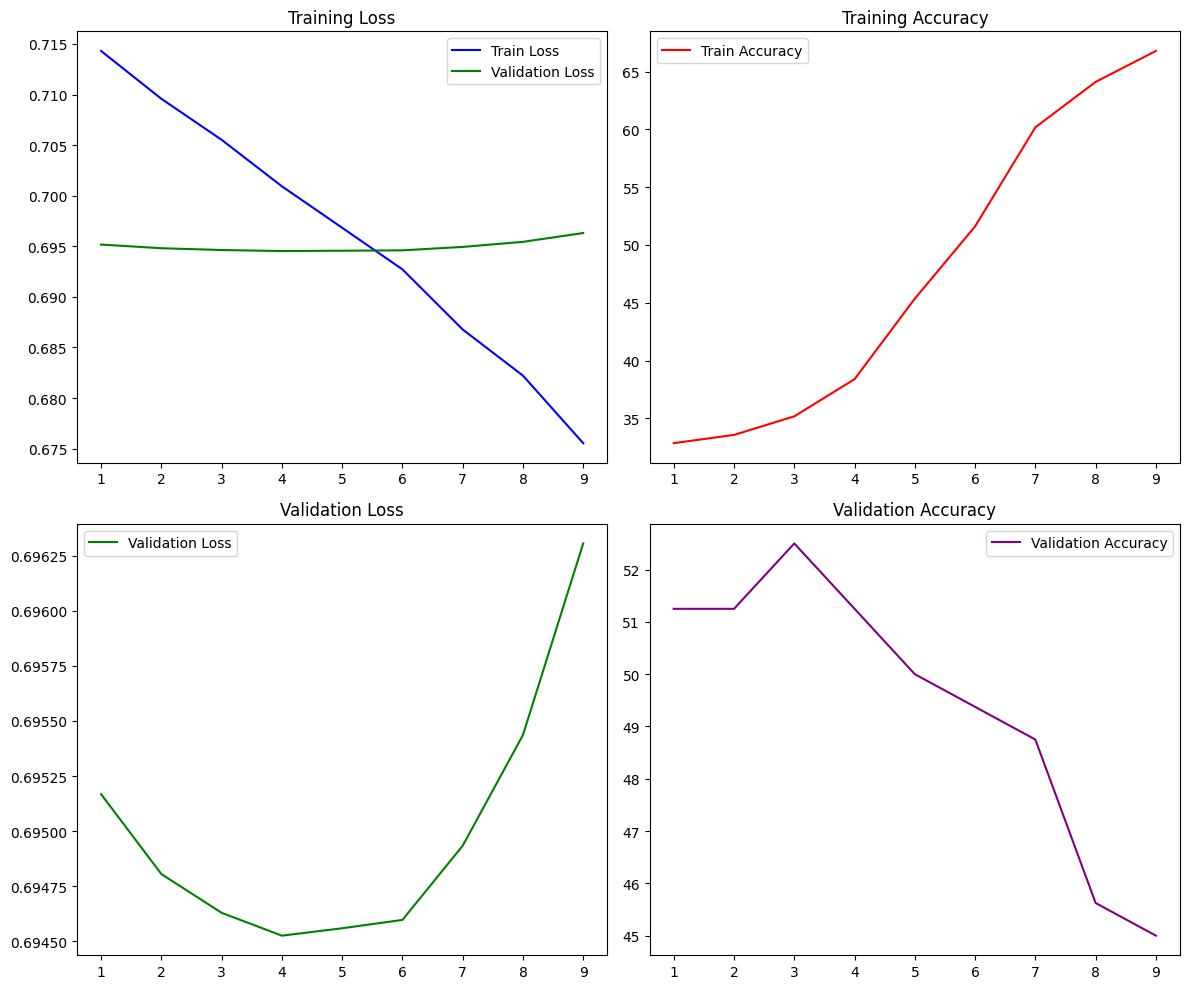

53.75

In [73]:
res = pipeline(X,y)
res

Testing Model: lr=1e-05, hidden_size=32, num_layers=3

In [9]:

model = LSTMRegression(n_features=X_train.shape[2], seq_length=X_train.shape[1], n_hidden=20, n_layers=2)

model.load_state_dict(torch.load("/content/Mejor modeloRelMatch.pth"))
model.eval()


<ipython-input-9-5f2759472c31>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/Mejor modeloRelMatch.pth"))


LSTMRegression(
  (l_lstm): LSTM(360, 20, num_layers=2, batch_first=True, dropout=0.3)
  (l_linear): Linear(in_features=20, out_features=1, bias=True)
)

In [47]:
def test_best_model(X_test, y_test, criterion):

    model = LSTMRegression(n_features=X_test.shape[2], seq_length=X_test.shape[1], n_hidden=20, n_layers=2)
    model.load_state_dict(torch.load("/content/best_model.pth", weights_only=True))

    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test).item()
    y_test_pred_class = torch.sigmoid(y_test_pred).argmax(dim=1)
    correct_test = (y_test_pred_class == y_test).sum().item()
    test_accuracy = correct_test / y_test.size(0)

    return test_loss, test_accuracy



def test_best_model(X_test, y_test):
    model = LSTMRegression(n_features=X_test.shape[2], seq_length=X_test.shape[1], n_hidden=20, n_layers=2)
    model.load_state_dict(torch.load("/content/best_model.pth", weights_only=True))
    model.eval()

    # Calculate Test Accuracy
    with torch.no_grad():
        y_test_pred = model(X_test)
        y_test_pred_class = (torch.sigmoid(y_test_pred) >= 0.5).long()

        # Ensure both tensors are 1D for comparison
        y_test = y_test.squeeze()
        y_test_pred_class = y_test_pred_class.squeeze()

        # Compare predictions with ground truth
        correct_test = (y_test_pred_class == y_test).sum().item()
        total_test = y_test.size(0)

        test_accuracy = correct_test / total_test * 100

    return test_accuracy

In [48]:
res = test_best_model(X_test, y_test)
res


78.75

In [56]:
def test_best_model(X_test, y_test):
    model = LSTMRegression(n_features=X_test.shape[2], seq_length=X_test.shape[1], n_hidden=32, n_layers=3)
    model.load_state_dict(torch.load("/content/MejorGender.pth", weights_only=True))
    model.eval()

    X_test = X_test.type(torch.float32)

    # Calculate Test Accuracy
    with torch.no_grad():
        y_test_pred = model(X_test)
        y_test_pred_class = (torch.sigmoid(y_test_pred) >= 0.5).long()

        # Ensure both tensors are 1D for comparison
        y_test = y_test.squeeze()
        y_test_pred_class = y_test_pred_class.squeeze()

        # Compare predictions with ground truth
        correct_test = (y_test_pred_class == y_test).sum().item()
        total_test = y_test.size(0)

        test_accuracy = correct_test / total_test * 100

    return test_accuracy

In [57]:
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
res = test_best_model(X_test, y_test)
res

<ipython-input-57-ad91c7b20c8e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


50.0